In [28]:
import matplotlib.pyplot as plt
import wntr
import wntr.network.controls as controls
import sqlite3
import csv
import time
import pandas as pd
from platform import python_version

In [30]:
def get_node_list_by_type(list, type):
    result = []
    for node in list:
        if wn.get_node(node).node_type == type:
            result.append(str(node))
    return result

def get_link_list_by_type(list, type):
    result = []
    for link in list:
        if wn.get_link(link).link_type == type:
            result.append(str(link))
    return result

def create_node_header(list):
    result = []
    for node in list:
        result.append(node+"_LEVEL")
    return result

def create_link_header(list):
    result = []
    for link in list:
        result.append(link+"_FLOW")
        result.append(link+"_STATUS")
    return result

def get_controls(list):
    result = []
    for control in list:
        result.append(wn.get_control(control))
    return result

def create_control_dict(actuator):
    dummy_condition = controls.ValueCondition(wn.get_node('T1'), 'level', '>=', -1)
    act_dict = dict.fromkeys(['actuator', 'parameter', 'value', 'condition', 'name'])
    act_dict['actuator'] = wn.get_link(actuator)
    act_dict['parameter'] = 'status'
    act_dict['condition'] = dummy_condition
    act_dict['name'] = actuator
    if type(wn.get_link(actuator).status) is int:
        act_dict['value'] = act_dict['actuator'].status
    else:
        act_dict['value'] = act_dict['actuator'].status.value
    return act_dict
    
def register_results(results):
    values_list = []    
    values_list.extend([results.timestamp])
    
    #Results are divided into: nodes: reservoir and tanks, links: flows and status
    # Get tanks levels
    for tank in tank_list:
            values_list.extend([wn.get_node(tank).level])

    # Get pumps flows and status
    for pump in pump_list:
            values_list.extend([wn.get_link(pump).flow])

            if type(wn.get_link(pump).status) is int:
                values_list.extend([wn.get_link(pump).status])  # The value is an integer
            else:
                values_list.extend([wn.get_link(pump).status.value]) # The value is an attribute of status, integer

    # Get valves flows and status
    for valve in valve_list:
            values_list.extend([wn.get_link(valve).flow])

            if type(wn.get_link(valve).status) is int:
                values_list.extend([wn.get_link(valve).status])
            else:
                values_list.extend([wn.get_link(valve).status.value]) 
    return values_list

def update_controls():
    for control in control_list:
        update_control(control)

def update_control(control):
    act_name = '\'' + control['name'] + '\''
    rows_1 = c.execute('SELECT value FROM ctown WHERE name = ' + act_name).fetchall()
    conn.commit()
    new_status = int(rows_1[0][0])

    control['value'] = new_status

    #act1 = controls.ControlAction(pump1, 'status', int(pump1_status))
    new_action  = controls.ControlAction(control['actuator'], control['parameter'], control['value'])

    #pump1_control = controls.Control(condition, act1, name='pump1control')
    new_control = controls.Control(control['condition'], new_action, name=control['name'])

    wn.remove_control(control['name'])
    wn.add_control(control['name'], new_control)

In [31]:
# Create the network
inp_file = 'wadi_map.inp'
wn = wntr.network.WaterNetworkModel(inp_file)

# Set option for step-by-step simulation
wn.options.time.duration = 1

list_header = []
node_list = list(wn.node_name_list)
link_list = list(wn.link_name_list)
wntr_only = 1
tank_list      = get_node_list_by_type(node_list, 'Tank')
pump_list      = get_link_list_by_type(link_list, 'Pump')
valve_list     = get_link_list_by_type(link_list, 'Valve')

list_header = ["Timestamps"]
aux = create_node_header(tank_list)
list_header.extend(aux)

aux = create_link_header(pump_list)
list_header.extend(aux)

aux = create_link_header(valve_list)
list_header.extend(aux)

results_list = []
results_list.append(list_header)

control_list = []
for valve in valve_list:
    control_list.append(create_control_dict(valve))

for pump in pump_list:
    control_list.append(create_control_dict(pump))

if wntr_only == 1:
    for control in control_list:
        an_action = controls.ControlAction(control['actuator'], control['parameter'], control['value'])
        a_control = controls.Control(control['condition'], an_action, name=control['name'])
        wn.add_control(control['name'], a_control)


In [32]:
for control in wn.controls():
    print(control)

('V_Gi_G', <Control: 'V_Gi_G', <ValueCondition: T1, level, >=, -1.0>, [<ControlAction: V_Gi_G, status, Open>], [], priority=3>)
('V_Gi_B', <Control: 'V_Gi_B', <ValueCondition: T1, level, >=, -1.0>, [<ControlAction: V_Gi_B, status, Closed>], [], priority=3>)
('V_SWaT', <Control: 'V_SWaT', <ValueCondition: T1, level, >=, -1.0>, [<ControlAction: V_SWaT, status, Closed>], [], priority=3>)
('V_PUB', <Control: 'V_PUB', <ValueCondition: T1, level, >=, -1.0>, [<ControlAction: V_PUB, status, Active>], [], priority=3>)
('V_ER2i', <Control: 'V_ER2i', <ValueCondition: T1, level, >=, -1.0>, [<ControlAction: V_ER2i, status, Active>], [], priority=3>)
('V_ER2o', <Control: 'V_ER2o', <ValueCondition: T1, level, >=, -1.0>, [<ControlAction: V_ER2o, status, Active>], [], priority=3>)
('V_ER1i', <Control: 'V_ER1i', <ValueCondition: T1, level, >=, -1.0>, [<ControlAction: V_ER1i, status, Closed>], [], priority=3>)
('V_ER1o', <Control: 'V_ER1o', <ValueCondition: T1, level, >=, -1.0>, [<ControlAction: V_ER1o, 

In [33]:
# START STEP BY STEP SIMULATION
sim = wntr.sim.EpanetSimulator(wn)
iteration = 0
iteration_limit = (14*60)/5
while iteration <= iteration_limit:
    
    #update_actuator_values()
    results = sim.run_sim()
    values_list = register_results(results)
    
    results_list.append(values_list)    
    iteration += 1

EpanetException: EPANET Error 200

In [7]:
with open('wadi_55_no_minicps.csv', 'w', newline='\n') as f:
    writer = csv.writer(f)
    writer.writerows(results_list)

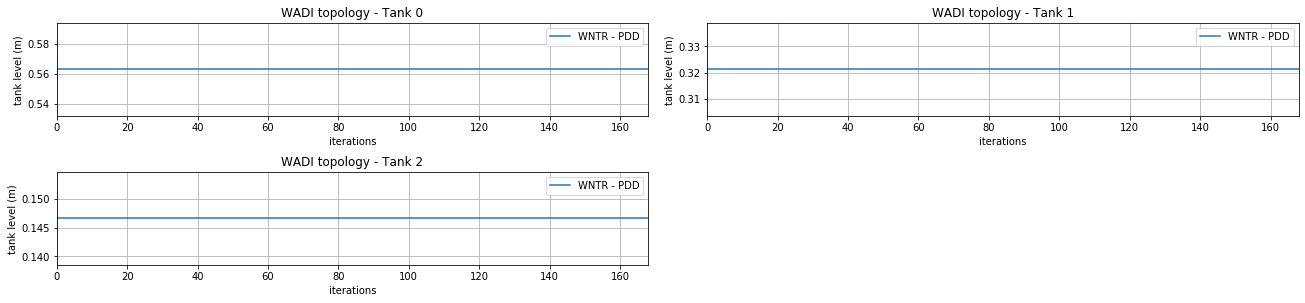

In [8]:
no_minicps_wadi = pd.read_csv('wadi_55_no_minicps.csv')

subplot_hspace = 0.6
subplot_wspace = 0.1

dd = plt.subplot(4,2,1)
no_minicps_wadi["T0_LEVEL"].plot(label='WNTR - PDD', ax=dd)
plt.title("WADI topology - Tank 0")
plt.xlabel('iterations')
plt.ylabel('tank level (m)')
plt.legend()
plt.subplots_adjust(top=2.00, right=3.00, hspace = subplot_hspace, wspace=subplot_wspace)
plt.grid(True)

dd = plt.subplot(4,2,2)
no_minicps_wadi["T1_LEVEL"].plot(label='WNTR - PDD', ax=dd)
plt.title("WADI topology - Tank 1")
plt.xlabel('iterations')
plt.ylabel('tank level (m)')
plt.legend()
plt.subplots_adjust(top=2.00, right=3.00, hspace = subplot_hspace, wspace=subplot_wspace)
plt.grid(True)

dd = plt.subplot(4,2,3)
no_minicps_wadi["T2_LEVEL"].plot(label='WNTR - PDD', ax=dd)
plt.title("WADI topology - Tank 2")
plt.xlabel('iterations')
plt.ylabel('tank level (m)')
plt.legend()
plt.subplots_adjust(top=2.00, right=3.00, hspace = subplot_hspace, wspace=subplot_wspace)
plt.grid(True)